## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], opt=False , drp_ratio = 0.25):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if opt:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=keras.regularizers.l2(1e-4))(input_layer)
                x = keras.layers.Dropout(drp_ratio)(x)
                x = keras.layers.BatchNormalization()(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(input_layer) 
        else:
            if opt:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=keras.regularizers.l2(1e-4))(x)
                x = keras.layers.Dropout(drp_ratio)(x)
                x = keras.layers.BatchNormalization()(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                       activation="relu", 
                       name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256

In [16]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i in range(2):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    if i==0:
        oName = 'optFalse'
        model = build_mlp(input_shape=x_train.shape[1:], opt=False)
    else:
        oName = 'optTrue'
        model = build_mlp(input_shape=x_train.shape[1:], opt=True)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = oName
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 282us/step - loss: 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 328us/step - loss: 2.2324 - acc: 0.2725 - val_loss: 2.1027 - val_acc: 0.2998
Epoch 2/50
50000/50000 [==============================] - 15s 297us/step - loss: 1.9373 - acc: 0.3509 - val_loss: 1.9849 - val_acc: 0.3195
Epoch 3/50
50000/50000 [==============================] - 15s 291us/step - loss: 1.8560 - acc: 0.3771 - val_loss: 1.8299 - val_acc: 0.3847
Epoch 4/50
50000/50000 [==============================] - 15s 293us/step - loss: 1.8091 - acc: 0.3924 - val_loss: 1.8014 - val_acc: 0.3906
Epoch 5/50
50000/50000 [==============================] - 16s 326us/step - loss: 1.7749 - acc: 0.4025 - val_loss: 1.8285 - val_acc: 0.3890
Epoch 6/50
50000/50000 [==============================] - 16s 319us/step - loss: 1.7644 - acc: 0.4048 - val_loss: 1.7285 - val_acc: 0.4148
Epoch 7/50
50000/50000 [==============================] - 15s 300us/step - loss: 1.7382 - acc: 0.4118 - val_loss: 1.

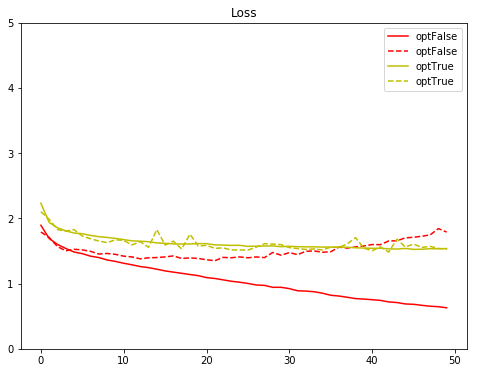

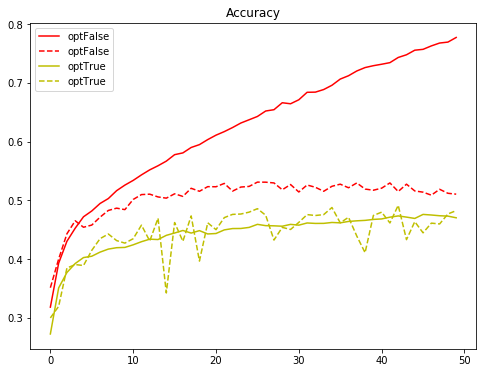

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()